In [30]:
import random

In [31]:
class GenotypeDecoder:
    
    def decode(self, genotype: str):
        return int(genotype, 2) ** 2

In [32]:
class Individual:
        
    def __init__(self, genotype: str, fitness: int):
        self.genotype = genotype
        self.fitness = fitness
        
    def __repr__(self):
        return "Individual/genotype = " + self.genotype + " Fitness = " + str(self.fitness)

In [33]:
class FitnessEvaluator:
    
    def __init__(self, genotype_decoder: GenotypeDecoder):
        self.genotype_decoder = genotype_decoder
        
    def evaluate(self, genotype: str):
        return self.genotype_decoder.decode(genotype)

In [34]:
class IndividualFactory:
    
    def __init__(self, genotype_length: int, fitness_evaluator: FitnessEvaluator):
        self.genotype_length = genotype_length
        self.fitness_evaluator = fitness_evaluator
        # E.g. {:032b} to format a number on 32 bits with leading zeros
        self.binary_string_format = '{:0' + str(self.genotype_length) + 'b}'
    
    def with_random_genotype(self):
        genotype_max_value = 2 ** self.genotype_length
        random_genotype = self.binary_string_format.format(random.randint(0, genotype_max_value))
        fitness = self.fitness_evaluator.evaluate(random_genotype)
        return Individual(random_genotype, fitness)
    
    def with_set_genotype(self, genotype: str):
        fitness = self.fitness_evaluator.evaluate(genotype)
        return Individual(genotype, fitness)
    
    def with_minimal_fitness(self):
        minimal_fitness_genotype = self.binary_string_format.format(0)
        fitness = self.fitness_evaluator.evaluate(minimal_fitness_genotype)
        return Individual(minimal_fitness_genotype, fitness)

In [35]:
class Population:
    
    def __init__(self, individuals):
        self.individuals = individuals
        
    def get_the_fittest(self, n: int):
        self.__sort_by_fitness()
        return self.individuals[:n]
        
    def __sort_by_fitness(self):
        self.individuals.sort(key = self.__individual_fitness_sort_key, reverse = True)
    
    def __individual_fitness_sort_key(self, individual: Individual):
        return individual.fitness

In [36]:
class PopulationFactory:
    
    def __init__(self, individual_factory: IndividualFactory):
        self.individual_factory = individual_factory
        
    def with_random_individuals(self, size: int):
        individuals = []
        for i in range(size):
            individuals.append(self.individual_factory.with_random_genotype())
        return Population(individuals)
    
    def with_individuals(self, individuals):
        return Population(individuals)
    
    def with_minimal_fitness_individuals(self, size: int):
        individuals = []
        for i in range(size):
            individuals.append(self.individual_factory.with_minimal_fitness())
        return Population(individuals)

In [37]:
class ParentSelector:
        
    def select_parents(self, population: Population):
        total_fitness = 0
        fitness_scale = []
        for index, individual in enumerate(population.individuals):
            total_fitness += individual.fitness
            if index == 0:
                fitness_scale.append(individual.fitness)
            else:
                fitness_scale.append(individual.fitness + fitness_scale[index - 1])
            
        # Store the selected parents
        mating_pool = []
        # Equal to the size of the population
        number_of_parents = len(population.individuals)
        # How fast we move along the fitness scale
        fitness_step = total_fitness / number_of_parents
        random_offset = random.uniform(0, fitness_step)
        
        # Iterate over the parents size range and for each:
        # - generate pointer position on the fitnss scale
        # - pick the parent who corresponds to the current pointer position and add them to the mating pool
        current_fitess_pointer = random_offset
        last_fitness_scale_position = 0
        for index in range(len(population.individuals)):
            for fitness_scale_position in range(last_fitness_scale_position, len(fitness_scale)):
                if fitness_scale[fitness_scale_position] >= current_fitess_pointer:
                    mating_pool.append(population.individuals[fitness_scale_position])
                    last_fitness_scale_position = fitness_scale_position
                    break
            current_fitess_pointer += fitness_step
        
        return mating_pool

In [38]:
class SinglePointCrossover:
    
    def __init__(self, individual_factory: IndividualFactory):
        self.individual_factory = individual_factory
    
    def crossover(self, parent_1: Individual, parent_2: Individual):
        crossover_point = random.randint(0, len(parent_1.genotype))
        genotype_1 = self.__new_genotype(crossover_point, parent_1, parent_2)
        genotype_2 = self.__new_genotype(crossover_point, parent_2, parent_1)
        child_1 = self.individual_factory.with_set_genotype(genotype = genotype_1)
        child_2 = self.individual_factory.with_set_genotype(genotype = genotype_2)
        return child_1, child_2
    
    def __new_genotype(self, crossover_point: int, parent_1: Individual, parent_2: Individual):
        return parent_1.genotype[:crossover_point] + parent_2.genotype[crossover_point:]

In [39]:
class Mutator:
    
    def __init__(self, individual_factory: IndividualFactory):
        self.individual_factory = individual_factory
        
    def mutate(self, individual: Individual):
        mutated_genotype = list(individual.genotype)
        mutation_probability = 1 / len(individual.genotype)
        for index, gene in enumerate(individual.genotype):
            if random.random() < mutation_probability:
                # print("Mutating gene " + gene + " at position " + str(index) + " of genotype " + genotype)
                mutated_genotype[index] = '0' if gene == '1' else '1' 
        return self.individual_factory.with_set_genotype(genotype = "".join(mutated_genotype))

In [40]:
class Breeder:
    
    def __init__(self, 
                 single_point_crossover: SinglePointCrossover,
                 mutator: Mutator):
        self.single_point_crossover = single_point_crossover
        self.mutator = mutator
        
    def produce_offspring(self, parents):
        offspring = []
        number_of_parents = len(parents)
        for index in range(int(number_of_parents / 2)):
            parent_1, parent_2 = self.__pick_random_parents(parents, number_of_parents)
            child_1, child_2 = self.single_point_crossover.crossover(parent_1, parent_2)
            child_1_mutated = mutator.mutate(child_1)
            child_2_mutated = mutator.mutate(child_2)
            offspring.extend((child_1_mutated, child_2_mutated))
        
        return offspring
    
    def __pick_random_parents(self, parents, number_of_parents: int):
        parent_1 = parents[random.randint(0, number_of_parents - 1)]
        parent_2 = parents[random.randint(0, number_of_parents - 1)]
        return parent_1, parent_2

In [41]:
class Environment:
    
    def __init__(self, 
                 population_size: int, 
                 parent_selector: ParentSelector, 
                 population_factory: PopulationFactory, 
                 breeder: Breeder):
        self.population_factory = population_factory
        # self.population = self.population_factory.with_minimal_fitness_individuals(size = population_size)
        self.population = self.population_factory.with_random_individuals(size = population_size)
        self.parent_selector = parent_selector
        self.breeder = breeder
    
    def update(self):
        parents = self.parent_selector.select_parents(self.population)
        next_generation = breeder.produce_offspring(parents)
        self.population = population_factory.with_individuals(next_generation)
        
    def get_the_fittest(self, n: int):
        return self.population.get_the_fittest(n)

Winner, winner, chicken dinner! We got there
Stopped at generation 1892. The fittest individual: 
Individual/genotype = 11111111111111111111 Fitness = 1099509530625


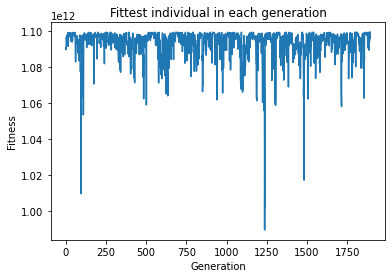

In [42]:
TOTAL_GENERATIONS = 10000
POPULATION_SIZE = 50
GENOTYPE_LENGTH = 20

current_generation = 1

genotype_decoder = GenotypeDecoder()
fitness_evaluator = FitnessEvaluator(genotype_decoder)
individual_factory = IndividualFactory(GENOTYPE_LENGTH, fitness_evaluator)
population_factory = PopulationFactory(individual_factory)
single_point_crossover = SinglePointCrossover(individual_factory)
mutator = Mutator(individual_factory)
breeder = Breeder(single_point_crossover, mutator)
parent_selector = ParentSelector()
environment = Environment(POPULATION_SIZE, 
                          parent_selector, 
                          population_factory, 
                          breeder)

highest_fitness_list = []
while current_generation <= TOTAL_GENERATIONS:
    fittest = environment.get_the_fittest(1)[0]
    highest_fitness_list.append(fittest.fitness)
    if "0" not in fittest.genotype:
        print("Winner, winner, chicken dinner! We got there")
        break
    environment.update()
    current_generation += 1

print("Stopped at generation " + str(current_generation - 1) + ". The fittest individual: ")
print(fittest)

import matplotlib.pyplot as plt

generations = range(1, len(highest_fitness_list) + 1)
plt.plot(generations, highest_fitness_list)
plt.title('Fittest individual in each generation')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()